# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 1) Imports and reading data

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

% matplotlib inline


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2) Getting the hang of Data

Viewing the dataframe tables using head(),info() and describe()

### a) Portfolio dataframe

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


### b) Profile dataframe

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.shape

(17000, 5)

In [8]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


### c) Transcript dataframe

In [10]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript.shape

(306534, 4)

In [12]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [13]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# 3) Idea of Workflow

So the basic idea here is to preprocess each dataframe seperately in order to derive features from them and then combine all the 3 dataframes to form a singlr dataframe which can be fed to the model.This model will predict the respective target variable given to it. 

## 4) Preprocessing

### a) Portfolio dataframe

Step 1 : Converting offertype in to columns with 1 indicating the corresponding offertype

In [14]:
dummy_offer = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')

portfolio = pd.concat([portfolio, dummy_offer], axis = 1)

portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,offer_bogo,offer_discount,offer_informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0


Step 2 : Converting channel column into binary values(One-hot encoding)

In [15]:
pf = portfolio.copy()
dummy_channel = pd.get_dummies(pf.channels.apply(pd.Series).stack()).sum(level=0)

portfolio = pd.concat([pf, dummy_channel], axis = 1)

portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,offer_bogo,offer_discount,offer_informational,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


Now as we don't need the columns channels,we could drop them.

In [16]:
portfolio = portfolio.drop(columns='channels')

rename 'id' as 'profile_id' as we dont want to mix up with multiple columns with same name as we merge the dataframes

In [17]:
portfolio = portfolio.rename(columns = {'id': 'offer_id'})

In [18]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,offer_bogo,offer_discount,offer_informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


In [19]:
portfolio.shape

(10, 12)

In [20]:
portfolio.groupby('offer_type')['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

### b) Profile dataframe

In [21]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [22]:
#changing the format of datetime
profile['membership_date'] = pd.to_datetime(profile['became_member_on'],format = '%Y%m%d')
profile = profile.drop(columns='became_member_on')

rename 'id' as 'customer_id' as we dont want to mix up with multiple columns with same name as we merge the dataframes

In [23]:
profile = profile.rename(columns = {'id': 'customer_id'})

In [24]:
profile.head()

,age,gender,customer_id,income,membership_date
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04


In [25]:
profile.isnull().sum()

age                   0
gender             2175
customer_id           0
income             2175
membership_date       0
dtype: int64

As we have so many null values in this dataframe we need to remove those before modelling

In [26]:
profile.replace(118,np.nan,inplace = True)
profile['age'] = profile['age'].fillna(profile['age'].mean())
profile['income'] = profile['income'].fillna(profile['income'].mean())

gender_mode = profile['gender'].mode()[0]
profile['gender'] = profile['gender'].fillna(gender_mode)

In [27]:
profile.isnull().sum()

age                0
gender             0
customer_id        0
income             0
membership_date    0
dtype: int64

### c) Transcript dataframe

In [28]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [29]:
#rename person as customer_id 
transcript = transcript.rename(columns = {'person': 'customer_id'})

In [30]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [31]:
tc = transcript.copy()
dummy_events = pd.get_dummies(tc['event'])

transcript = pd.concat([tc,dummy_events],axis=1)


In [32]:
transcript.head()

,event,customer_id,time,value,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [33]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [34]:
#Converting dict in to columns
transcript['offer_id'] = transcript['value'].apply(lambda a : a.get('offer_id'))
transcript['offer id'] = transcript['value'].apply(lambda a : a.get('offer id'))
transcript['earnings'] = transcript['value'].apply(lambda a : a.get('reward'))
transcript['expense'] =  transcript['value'].apply(lambda a : a.get('amount'))

In [35]:
#merging the 2 columns ('offer id' and 'offer_id')
transcript['offer_id'] = transcript.apply(lambda a : a['offer id'] if a['offer_id'] == None else a['offer_id'],axis = 1)

In [36]:
#dropping the unnecessary columns (ie 'offer id' and 'value')
transcript.drop(['offer id','value'], axis=1,inplace = True)

In [37]:
transcript.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer_id,earnings,expense
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [38]:
transcript.fillna(0,inplace=True)
transcript.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer_id,earnings,expense
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


Now that we have processed each dataframes seperately,we need to merge them together to make a single dataframe

In [39]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,offer_bogo,offer_discount,offer_informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


In [40]:
profile.head()

,age,gender,customer_id,income,membership_date
0,54.393524,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017-02-12
1,55.000000,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017-07-15
2,54.393524,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018-07-12
3,75.000000,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017-05-09
4,54.393524,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017-08-04


In [41]:
transcript.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer_id,earnings,expense
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


# 5) Merging the dataframes

As 'profile' and 'transcript' have a common column.. ie 'customer_id',those to dataframes could be merged along that column.

In [42]:
df_final = pd.merge(transcript,profile,on='customer_id')

Similarly 'portfolio' and 'transcript' have a common column - 'offer_id'.We merge those along that column

In [43]:
df_final = pd.merge(portfolio,df_final,on='offer_id')

In [44]:
df_final.head()

,difficulty,duration,offer_id,offer_type,reward,offer_bogo,offer_discount,offer_informational,email,mobile,...,offer completed,offer received,offer viewed,transaction,earnings,expense,age,gender,income,membership_date
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,...,0,1,0,0,0.0,0.0,75.000000,F,100000.000000,2017-05-09
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,...,0,0,1,0,0.0,0.0,75.000000,F,100000.000000,2017-05-09
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,...,1,0,0,0,10.0,0.0,75.000000,F,100000.000000,2017-05-09
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,...,0,1,0,0,0.0,0.0,54.393524,M,65404.991568,2017-10-02
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,...,0,1,0,0,0.0,0.0,54.393524,M,65404.991568,2017-08-24


In [45]:
df_final.shape

(167581, 25)

In [46]:
df_final.columns

Index(['difficulty', 'duration', 'offer_id', 'offer_type', 'reward',
       'offer_bogo', 'offer_discount', 'offer_informational', 'email',
       'mobile', 'social', 'web', 'event', 'customer_id', 'time',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'earnings', 'expense', 'age', 'gender', 'income', 'membership_date'],
      dtype='object')

In [47]:
df_final.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

# 6) Insights from the data

In [48]:
df_final['offer_id'].unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [49]:
df_final['offer_id'].nunique()

10

There are 10 unique offer_ids in the entire data.As they are in the form of strinngs,we need to encode them as integer values so that it can be used by the model.

### a) Income distribution

Text(0.5,0,'Income bins')

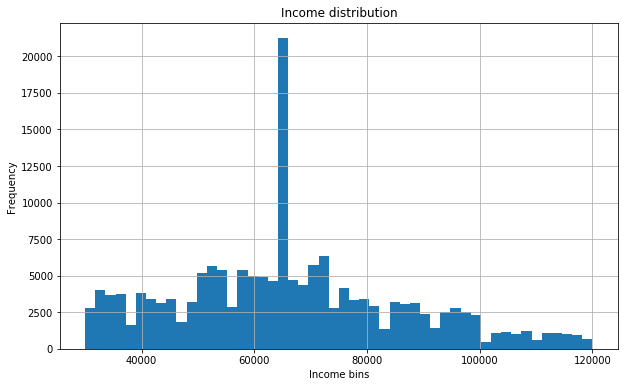

In [50]:
plt.figure(figsize=(10,6));
df_final.income.hist(bins=50)
plt.title('Income distribution')
plt.ylabel('Frequency')
plt.xlabel('Income bins')

The income distribution looks like a skewed normal distribution

### b) Gender based distribution

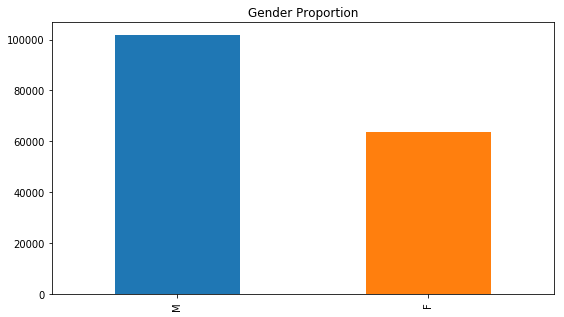

In [51]:
plt.figure(figsize=(9,5));

df_final[df_final['gender']!='O']['gender'].value_counts().plot.bar(title='Gender Proportion')

So we have higher male proportion than females

###    (i) Event type based on gender

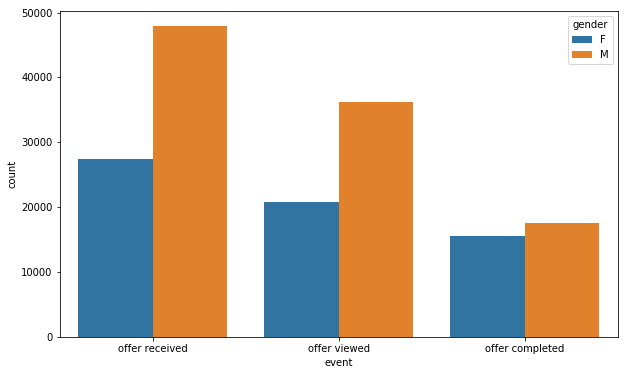

In [52]:
import seaborn as sns
plt.figure(figsize=(10,6));
sns.countplot(x='event',hue='gender',data=df_final[df_final['gender']!='O'])

### (ii) Offer type based on gender

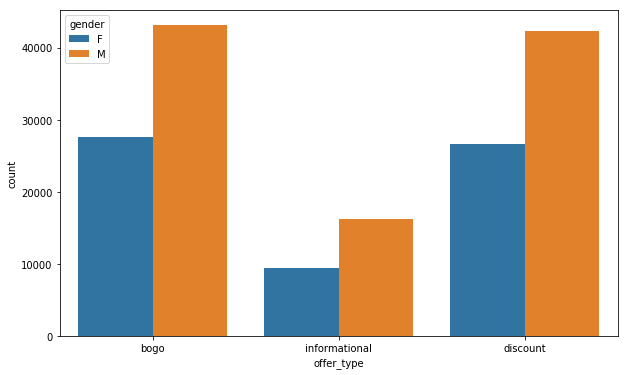

In [53]:
plt.figure(figsize=(10,6));
sns.countplot(x='offer_type',hue='gender',data=df_final[df_final['gender']!='O'])

The count of Male dominated over female in every individual subsection as well.

### c) Age distribution

Text(0.5,0,'Age bins')

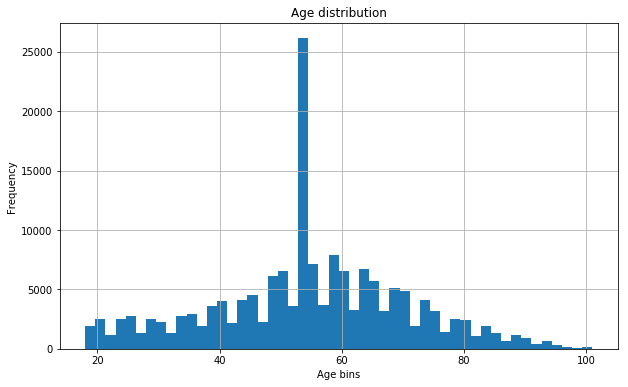

In [54]:
plt.figure(figsize=(10,6));
df_final.age.hist(bins=50)
plt.title('Age distribution')
plt.ylabel('Frequency')
plt.xlabel('Age bins')

The age distribution is similar to that of a normal distribution curve

## 7) Mapping strings with integers

### Reason
The model cannot process features in string format.so we need to convert it into numbers so that they ccn be used in equations to calculate the cost function which should be optimized in order totrain the model for better predictions.This is done by map finction

In [55]:
#mapping gender column
gender_type = {'O':0,'M':1,'F':2}

df_final['gender'] = df_final['gender'].map(gender_type)

In [56]:
#mapping offertype column
offer_type = {'bogo':1,'discount':2,'informational':3}

df_final['offer_type'] = df_final['offer_type'].map(offer_type)

In [57]:
#mapping event column
event_type = {'offer received':1,'offer viewed':2,'offer completed':3}

df_final['event'] = df_final['event'].map(event_type)

In [58]:
#mapping offer_id column
offer_id_type = list(df_final['offer_id'].unique())
val_to_map = dict(zip(offer_id_type,range(1,len(offer_id_type)+1)))
df_final.replace({'offer_id':val_to_map},inplace=True)

In [59]:
#mapping customer_id column
customer_id_type = list(df_final['customer_id'].unique())
val_to_map = dict(zip(customer_id_type,range(1,len(customer_id_type)+1)))
df_final.replace({'customer_id':val_to_map},inplace=True)

In [60]:
#taking month and year from membership_date column

df_final['membership_month'] = df_final['membership_date'].apply(lambda a:a.month)
df_final['membership_year'] = df_final['membership_date'].apply(lambda a:a.year)

In [61]:
df_final.head(10)

,difficulty,duration,offer_id,offer_type,reward,offer_bogo,offer_discount,offer_informational,email,mobile,...,offer viewed,transaction,earnings,expense,age,gender,income,membership_date,membership_month,membership_year
0,10,7,1,1,10,1,0,0,1,1,...,0,0,0.0,0.0,75.000000,2,100000.000000,2017-05-09,5,2017
1,10,7,1,1,10,1,0,0,1,1,...,1,0,0.0,0.0,75.000000,2,100000.000000,2017-05-09,5,2017
2,10,7,1,1,10,1,0,0,1,1,...,0,0,10.0,0.0,75.000000,2,100000.000000,2017-05-09,5,2017
3,10,7,1,1,10,1,0,0,1,1,...,0,0,0.0,0.0,54.393524,1,65404.991568,2017-10-02,10,2017
4,10,7,1,1,10,1,0,0,1,1,...,0,0,0.0,0.0,54.393524,1,65404.991568,2017-08-24,8,2017
5,10,7,1,1,10,1,0,0,1,1,...,1,0,0.0,0.0,54.393524,1,65404.991568,2017-08-24,8,2017
6,10,7,1,1,10,1,0,0,1,1,...,0,0,10.0,0.0,54.393524,1,65404.991568,2017-08-24,8,2017
7,10,7,1,1,10,1,0,0,1,1,...,0,0,0.0,0.0,61.000000,2,57000.000000,2017-09-11,9,2017
8,10,7,1,1,10,1,0,0,1,1,...,0,0,10.0,0.0,61.000000,2,57000.000000,2017-09-11,9,2017
9,10,7,1,1,10,1,0,0,1,1,...,1,0,0.0,0.0,61.000000,2,57000.000000,2017-09-11,9,2017


In [62]:
df_final.columns

Index(['difficulty', 'duration', 'offer_id', 'offer_type', 'reward',
       'offer_bogo', 'offer_discount', 'offer_informational', 'email',
       'mobile', 'social', 'web', 'event', 'customer_id', 'time',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'earnings', 'expense', 'age', 'gender', 'income', 'membership_date',
       'membership_month', 'membership_year'],
      dtype='object')

In [63]:
df_final = df_final.drop('membership_date',axis = 1)

In [64]:
df_final.dtypes

difficulty               int64
duration                 int64
offer_id                 int64
offer_type               int64
reward                   int64
offer_bogo               uint8
offer_discount           uint8
offer_informational      uint8
email                    uint8
mobile                   uint8
social                   uint8
web                      uint8
event                    int64
customer_id              int64
time                     int64
offer completed          uint8
offer received           uint8
offer viewed             uint8
transaction              uint8
earnings               float64
expense                float64
age                    float64
gender                   int64
income                 float64
membership_month         int64
membership_year          int64
dtype: object

# 8) Modelling

The models that will be trained and benchmarked for two different cases are as follows,

1) **KNeighborsClassifier** - Classifier implementing the k-nearest neighbors vote.

2) **RandomForestClassifier** - A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.  

3) **AdaBoostClassifier** - An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.


4) **ExtraTreesClassifier** -  An extra-trees classifier is a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

5) **BaggingClassifier** - A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

### a) Preconditioning the model --- Min-Max Scaling

The data features can have different range of values and their absolute values have a big impact on performance of the model.So the significance of different features can be balanced by rescaling these range of values to a same interval.

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features_to_be_scaled = ['difficulty', 'duration','reward','time','earnings', 'expense','income' ]

df_final[features_to_be_scaled] = scaler.fit_transform(df_final[features_to_be_scaled])

In [66]:
df_final.head()

,difficulty,duration,offer_id,offer_type,reward,offer_bogo,offer_discount,offer_informational,email,mobile,...,offer received,offer viewed,transaction,earnings,expense,age,gender,income,membership_month,membership_year
0,0.5,0.571429,1,1,1.0,1,0,0,1,1,...,1,0,0,0.0,0.0,75.000000,2,0.777778,5,2017
1,0.5,0.571429,1,1,1.0,1,0,0,1,1,...,0,1,0,0.0,0.0,75.000000,2,0.777778,5,2017
2,0.5,0.571429,1,1,1.0,1,0,0,1,1,...,0,0,0,1.0,0.0,75.000000,2,0.777778,5,2017
3,0.5,0.571429,1,1,1.0,1,0,0,1,1,...,1,0,0,0.0,0.0,54.393524,1,0.393389,10,2017
4,0.5,0.571429,1,1,1.0,1,0,0,1,1,...,1,0,0,0.0,0.0,54.393524,1,0.393389,8,2017


### b) Principal Component Analysis (PCA)

This is done to identify the features which are highly connected to the target variable,so that we can reduce the number of features by maintaining the required variance and that make the model training even more efficient.


In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class pca:
  """
  variable selection uisng pca
  """
  def __init__(self, data, col, required_variance=.90):
    self.data = data
    self.col = col
    self.required_variance = required_variance
    self.cleaning()
    self.n_components = self.identify_n_components(self.required_variance)
  
  def cleaning(self):
    self.data = self.data.replace([np.inf, -np.inf, np.nan], 0 )
  

  def identify_n_components(self, required_variance):
    # mean-centers and auto-scales the data
    standardizedData = StandardScaler().fit_transform(self.data[self.col])
    pca = PCA(required_variance)
    principalComponents = pca.fit_transform(X = standardizedData)
    #print(principalComponents)
    return pca.n_components_, pca.explained_variance_ratio_.sum()
  
    

In [68]:
col = df_final.columns.tolist()

In [69]:
#col = df_final.columns.tolist()
df_final.replace([np.inf, - np.inf], np.nan, inplace = True)
df_final = df_final.dropna() 
out = pca(df_final, col,required_variance=.99).identify_n_components(required_variance=.99)
print('Number of Principle Components : ' ,out[0])
print('Variance Captured : ' ,out[1])

Number of Principle Components :  16
Variance Captured :  0.991165564251


### Inference
So with 16 features we were able to capture almost 99% of the variance out of the non linear data.In case of too many features we can remove the unnecessary features and only give the required one to the model.In this case as we only have a few more than 16,lets give it all to the model and see how it performs with that.

###  c) Test-Train Splitting

Now the data should be splitted into test set and train set inorder to validate the predicting power of the ML model.Here we will be performing an 80%-20% split.Initially we need to choose a target variable which would be predicted by the model.

## Case 1 

#### Target Variable - Offer Type

Here the model predicts the offer_type using all the other features.ie it classiffies the data into corresponding offer types,ie

a) bogo

b) discount

c) informational

In [70]:
from sklearn.model_selection import train_test_split

target = df_final['offer_type']
data = df_final.drop(['offer_type','difficulty', 'duration', 'offer_id', 'reward',
       'offer_bogo', 'offer_discount', 'offer_informational'],axis = 1)

X_train,X_test,Y_train,Y_test = train_test_split(data,target,test_size=0.2,random_state = 0)

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(134064, 18) (33517, 18) (134064,) (33517,)


### a) Metrics and scoring --- quantifying the quality of predictions

Out of many metrics available in the sklearn framework,accuracy_score was selected as the evaluation metric as it is considered as the weighted average of precision and recall.The best performing model will have a accuracy value near 100 and the worsmodel will have accuracy_score closer to 0.

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier,BaggingClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,fbeta_score,accuracy_score
from sklearn import linear_model


In [72]:
model1 = KNeighborsClassifier(n_neighbors=6)
model2 = RandomForestClassifier(random_state=1)
model3 = AdaBoostClassifier(random_state=4)
model4 = ExtraTreesClassifier(random_state=10)
model5 = BaggingClassifier(random_state=120)

models = [model1,model2,model3,model4,model5]
model_name = ['KNN','RandomForest','AdaBoost','ExtraTrees','Bagging']

In [73]:
def training(model):
    X_train,X_test,Y_train,Y_test = train_test_split(data,target,test_size=0.2,random_state =10)
    model_name = model.fit(X_train,Y_train)
    predictions_train = model_name.predict(X_train)
    predictions_test = model_name.predict(X_test)
    train_accuracy = accuracy_score(Y_train,predictions_train) * 100
    test_accuracy = accuracy_score(Y_test,predictions_test)*100
    #print(model,train_accuracy,test_accuracy)
    return train_accuracy,test_accuracy

### b) Benchmarking the models

In [74]:
scores=[]
for i in range(len(models)):
    np.random.seed(42)
    train_score,test_score = training(models[i])
    scores.append([model_name[i],train_score,test_score])
    
scores = pd.DataFrame(scores)
scores.columns = ["Model", "train_score", "test_score"]
scores = scores.set_index('Model')
scores

,train_score,test_score
Model,,
KNN,68.918576,55.258526
RandomForest,98.494003,69.245458
AdaBoost,63.772527,63.710953
ExtraTrees,100.000000,67.482173
Bagging,99.306301,82.561088


### c) Training score comparison

Text(0,0.5,'Accuracy')

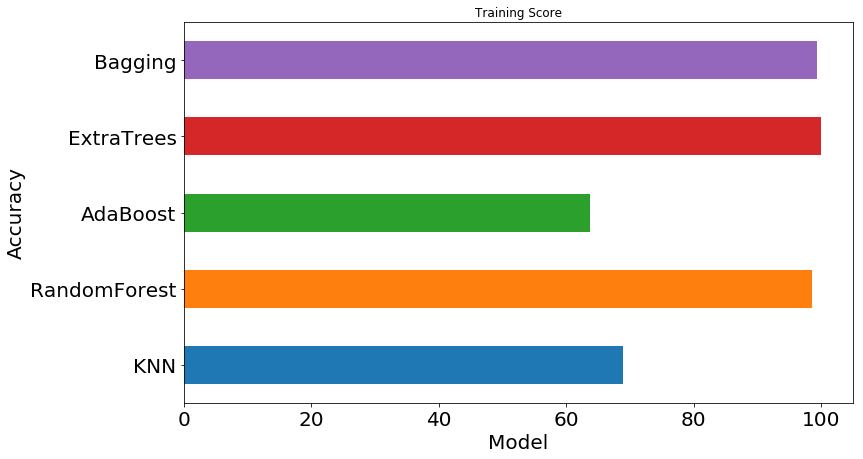

In [75]:
plt.figure(figsize=(12,7));
scores.train_score.plot.barh(title='Training Score',fontsize=20)
plt.xlabel('Model',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)

### d) Testing score comparison


Text(0,0.5,'Accuracy')

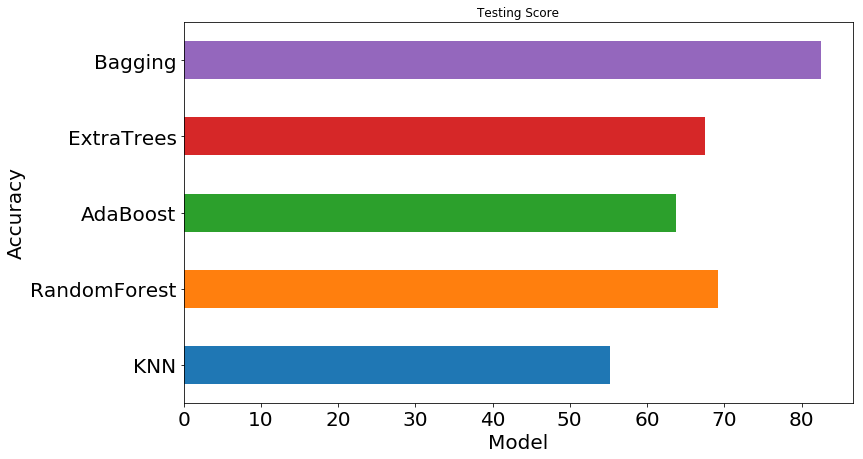

In [76]:
plt.figure(figsize=(12,7));
scores.test_score.plot.barh(title='Testing Score',fontsize=20)
plt.xlabel('Model',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)

### Inference
This shows that apart from KNN model and AdaBoost model all the other three model performs really well to predict the type of offer.The Highest test_score is shown by Bagging Classifier which is the best to predict the type of offer.In predicitng the offer type,bagging classifier has the highest training as well as testing accuracy.So that wins the battle among all the other models in this particular case.

## Case 2 

#### Target Variable - Event type

Here the model predicts the event_type using all the other features.ie it classiffies the data into corresponding event types,ie
  
a) offer received    

b) offer viewed     

c) offer completed

In [77]:
target = df_final['event']
data = df_final.drop(['event','offer completed', 'offer received', 'offer viewed'],axis = 1)

X_train,X_test,Y_train,Y_test = train_test_split(data,target,test_size=0.2,random_state = 0)

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(134064, 22) (33517, 22) (134064,) (33517,)


### a) Benchmarking the models

In [78]:
scores=[]
for i in range(len(models)):
    train_score,test_score = training(models[i])
    scores.append([model_name[i],train_score,test_score])
    
scores = pd.DataFrame(scores)
scores.columns = ["Model", "train_score", "test_score"]
scores = scores.set_index('Model')
scores

,train_score,test_score
Model,,
KNN,51.808838,30.924605
RandomForest,92.922783,66.434943
AdaBoost,92.362603,92.329266
ExtraTrees,93.912609,51.702121
Bagging,93.658253,87.015544


### b) Training score comparison

Text(0,0.5,'Accuracy')

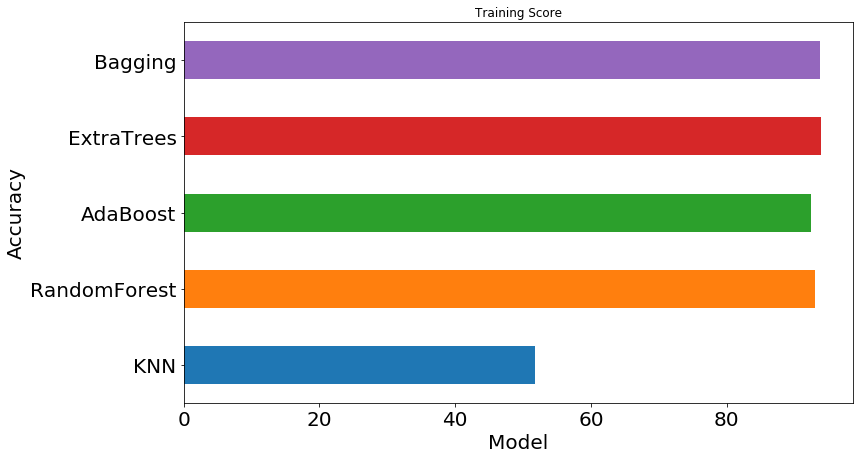

In [79]:
plt.figure(figsize=(12,7));
scores.train_score.plot.barh(title='Training Score',fontsize=20)
plt.xlabel('Model',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)

### c) Testing score comparison

Text(0,0.5,'Accuracy')

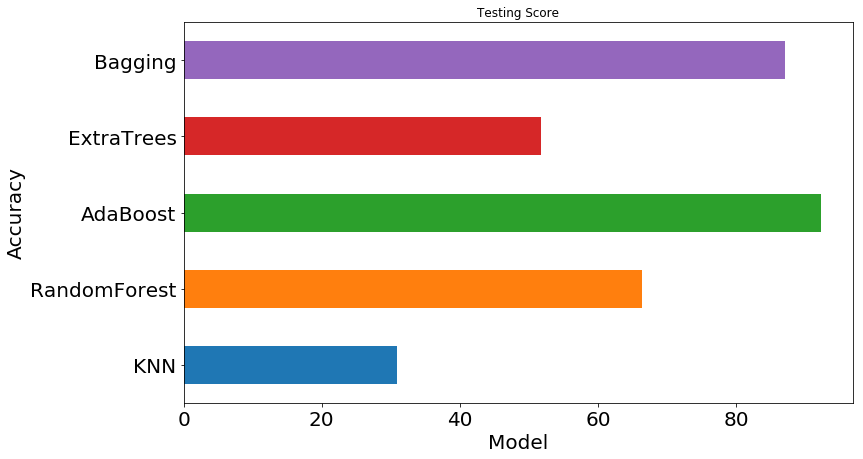

In [80]:
plt.figure(figsize=(12,7));
scores.test_score.plot.barh(title='Testing Score',fontsize=20)
plt.xlabel('Model',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)

### Inference
Here apart from KNN model every other model performs really well with accuracy above 90% in the case of training dataset.This may be due to the effective data preprocessing followed by the exploratory data analysis.But when it comes to validation of the model performance using the testing dataset,only the AdaBoost model performs well.So Adaboost classifier is the best one for this case.The performance of other models might have degraded due to the issue of overfitting.This can be rectified using addition of noise or with some regularization techniques.

## Conclusion

Initially the data in the form of 3 dataframes was processed separately using different techniques.Features were extraxcted from these individual dataframes and then cleaned to remove null values,infinite values etc.Now Feature engineering was performed in which diferent columns were extracted from some columns to make the data more readable to the model.One the individual dataframes were cleaned and modified,all of them were merged to form a single dataframe.Now this was fed to the models.So the model training and predictions were carried out for two cases by changing the target variable so that the models could predict multiple entities seperately.Initilly the model predicts the type of offer and then the type of event.5 different ML models were taken from Sklearn framework and were compared using the merged dataframe.The results of the model predicitions were also were also generated in order to find the model which performed well.regarding the scopes for improvement,The data set could have been made better by eliminating so many null values which I had to replace with appropriate counterparts.This would have reduced the quality of data.Other than that if we had more features to work with,we could have done PCA on a better data pool and obtained better results.

## References

1) https://stackoverflow.com/

2) https://pandas.pydata.org/docs/reference/index.html

3)  https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

4) Changing datetime format : https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

5) Merging dataframes along column : https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

6) One hot encoding : https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/

7) Mapping in pandas : https://kanoki.org/2019/04/06/pandas-map-dictionary-values-with-dataframe-columns/

8) Min-Max scaling : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

9) Metrics : https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

10) Factor Analyzer : https://pypi.org/project/factor-analyzer/

11) Dropping infinite values : https://statisticsglobe.com/drop-inf-from-pandas-dataframe-in-python

12) SkLearn ensembles : https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

13) https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

14) https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html

15) Visualization : https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-barplot

16) List of list to dataframe : https://datascience.stackexchange.com/questions/26333/convert-a-list-of-lists-into-a-pandas-dataframe

